In [ ]:
# Install CleverHans and ImageNet Stubs
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
!pip install git+https://github.com/nottombrown/imagenet_stubs

In [3]:
# Standard Imports
import numpy as np
import matplotlib.pyplot as plt

#Importing cleverhans and its attack method
import cleverhans
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

# Tensorflow, EfficientNet, and DenseNet  Imports
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import tensorflow.keras.applications.densenet as DenseNet
import tensorflow.keras.applications.efficientnet as EfficientNet


# Load Imagenet Stubs
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

In [4]:
print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())


Tensorflow Version: 2.5.0
Cleverhans Version: 4.0.0-dda3ed9309fe3cd6d5b746c5c9c440d8
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  False


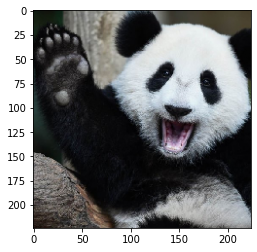

In [200]:
img_path = tf.keras.utils.get_file('Panda', origin= 'https://pbs.twimg.com/profile_images/829274786362699776/a1ttXfVG.jpg')

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x_dense = np.expand_dims(x.copy(), axis=0).astype(np.float) / 255.0
x_efficient = np.expand_dims(x, axis=0)
plt.imshow(x_dense[0]);

In [73]:
denseNetModel = DenseNet.DenseNet121(weights='imagenet')
efficientNetModel = EfficientNet.EfficientNetB0(weights="imagenet")

In [201]:
def predict(model, decode_predictions, sample):
  pred = model.predict(sample)
  label = np.argmax(pred, axis=1)[0]
  confidence = pred[:,label][0]
  prediction = "----- Prediction -----\n" + 'Prediction: ' + label_to_name(label) + ' - confidence ' + str(confidence) + "\n"
  probabilities = "--- Probabilities ----\n" + str(decode_predictions(pred))
  return prediction, probabilities

In [202]:
# check prediction and probabilities with DenseNet and EfficientNet
print('Dense Net')
pred, prob = predict(denseNetModel, DenseNet.decode_predictions, x_dense)
print(pred)
print(prob)

print('\n\nEfficient Net')

pred, prob = predict(efficientNetModel, EfficientNet.decode_predictions, x_efficient)
print(pred)
print(prob)

Dense Net
----- Prediction -----
Prediction: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca - confidence 0.8108951

--- Probabilities ----
[[('n02510455', 'giant_panda', 0.8108951), ('n04399382', 'teddy', 0.056070983), ('n02441942', 'weasel', 0.035980523), ('n02134084', 'ice_bear', 0.01085484), ('n02500267', 'indri', 0.010048871)]]


Efficient Net
----- Prediction -----
Prediction: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca - confidence 0.91325474

--- Probabilities ----
[[('n02510455', 'giant_panda', 0.91325474), ('n02509815', 'lesser_panda', 0.0025823459), ('n02500267', 'indri', 0.0018807286), ('n02134084', 'ice_bear', 0.00164911), ('n04399382', 'teddy', 0.0015198899)]]


In [203]:
# Generate FGSM Samples
fgsm_samples_densenet = fast_gradient_method(denseNetModel, x_dense, 0.005, np.inf, targeted=False, clip_min=0, clip_max=1)
# x_efficient_preprocess = EfficientNet.preprocess_input(x_efficient.copy())
fgsm_samples_efficientnet = fast_gradient_method(efficientNetModel, x_efficient, 0.005, np.inf, targeted=False, clip_min=0, clip_max=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


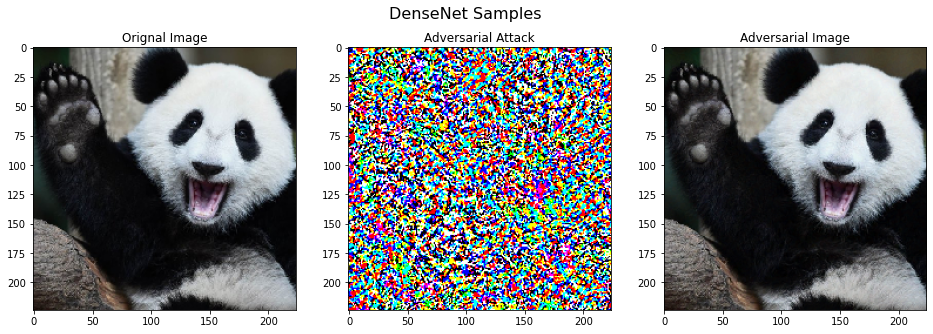

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


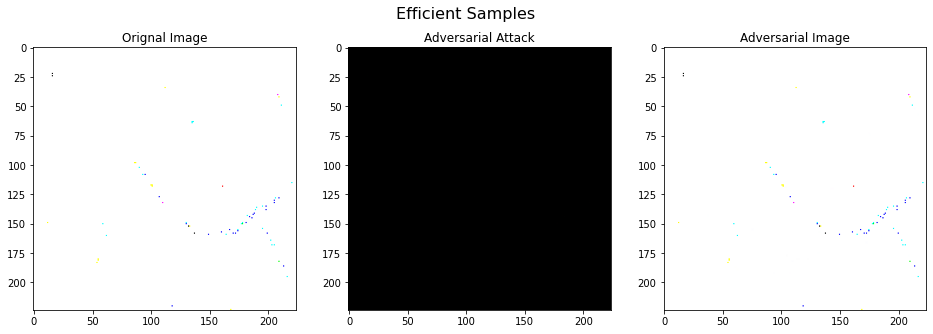

In [204]:
fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(1,3,1)
ax1.title.set_text('Orignal Image')
ax1.imshow((x_dense[0]))

ax2 = fig.add_subplot(1,3,2)
ax2.title.set_text('Adversarial Attack')
ax2.imshow((fgsm_samples_densenet.numpy()[0] - x_dense[0])*255)

ax2 = fig.add_subplot(1,3,3)
ax2.title.set_text('Adversarial Image')
ax2.imshow(fgsm_samples_densenet.numpy()[0])

plt.suptitle('DenseNet Samples', fontsize=16)
plt.show()

# Efficient Net Images

fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(1,3,1)
ax1.title.set_text('Orignal Image')
ax1.imshow((x_efficient[0]))

ax2 = fig.add_subplot(1,3,2)
ax2.title.set_text('Adversarial Attack')
ax2.imshow((fgsm_samples_efficientnet.numpy()[0] - x_efficient[0]))

ax2 = fig.add_subplot(1,3,3)
ax2.title.set_text('Adversarial Image')
ax2.imshow(fgsm_samples_efficientnet.numpy()[0])

plt.suptitle('Efficient Samples', fontsize=16)
plt.show()


In [205]:
print('Dense Net')
pred, prob = predict(denseNetModel, DenseNet.decode_predictions, fgsm_samples_densenet)
print(pred)
print(prob)

print('\n\nEfficient Net')

pred, prob = predict(efficientNetModel, EfficientNet.decode_predictions, fgsm_samples_efficientnet)
print(pred)
print(prob)

Dense Net
----- Prediction -----
Prediction: teddy, teddy bear - confidence 0.4234684

--- Probabilities ----
[[('n04399382', 'teddy', 0.4234684), ('n02808304', 'bath_towel', 0.13046682), ('n02441942', 'weasel', 0.02488258), ('n03026506', 'Christmas_stocking', 0.020765424), ('n04599235', 'wool', 0.017944278)]]


Efficient Net
----- Prediction -----
Prediction: matchstick - confidence 0.0016597342

--- Probabilities ----
[[('n03729826', 'matchstick', 0.0016597342), ('n01930112', 'nematode', 0.0016537149), ('n04372370', 'switch', 0.0016205277), ('n02002724', 'black_stork', 0.0016024717), ('n03637318', 'lampshade', 0.0015372031)]]


In [206]:
pgd_samples_densenet = projected_gradient_descent(denseNetModel, x_dense, eps_iter=0.01,eps=0.05, nb_iter=10, norm= np.inf, targeted=False)
# x_efficient_preprocess = EfficientNet.preprocess_input(x_efficient.copy())
pgd_samples_efficientnet = projected_gradient_descent(efficientNetModel, x_efficient, eps_iter=1,eps=5, nb_iter=10, norm= np.inf, targeted=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


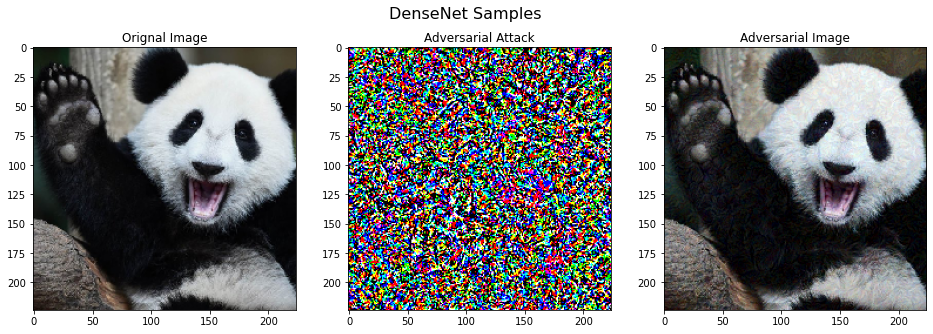

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


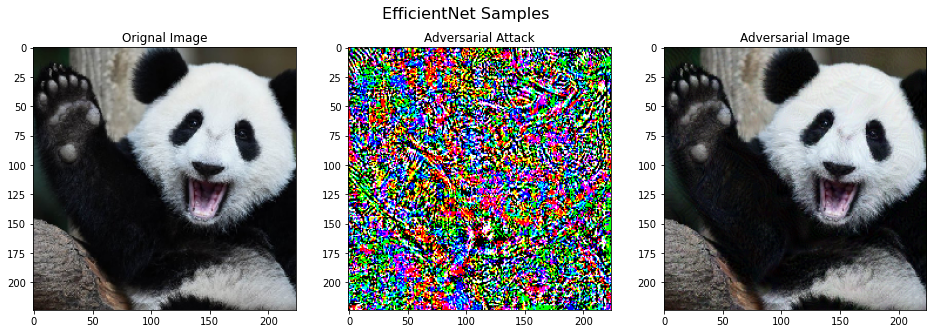

In [207]:
# Dense Net Images
fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(1,3,1)
ax1.title.set_text('Orignal Image')
ax1.imshow((x_dense[0]))

ax2 = fig.add_subplot(1,3,2)
ax2.title.set_text('Adversarial Attack')
ax2.imshow((pgd_samples_densenet.numpy()[0] - x_dense[0])*255)

ax2 = fig.add_subplot(1,3,3)
ax2.title.set_text('Adversarial Image')
ax2.imshow(pgd_samples_densenet.numpy()[0])

plt.suptitle('DenseNet Samples', fontsize=16)
plt.show()

# Efficient Net Images

fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(1,3,1)
ax1.title.set_text('Orignal Image')
ax1.imshow((x_efficient[0]/255))

ax2 = fig.add_subplot(1,3,2)
ax2.title.set_text('Adversarial Attack')
ax2.imshow((pgd_samples_efficientnet.numpy()[0] - x_efficient[0]))

ax2 = fig.add_subplot(1,3,3)
ax2.title.set_text('Adversarial Image')
ax2.imshow(pgd_samples_efficientnet.numpy()[0]/255)

plt.suptitle('EfficientNet Samples', fontsize=16)
plt.show()

In [208]:
print('Dense Net')
pred, prob = predict(denseNetModel, DenseNet.decode_predictions, pgd_samples_densenet)
print(pred)
print(prob)

print('\n\nEfficient Net')

pred, prob = predict(efficientNetModel, EfficientNet.decode_predictions, pgd_samples_efficientnet)
print(pred)
print(prob)

Dense Net
----- Prediction -----
Prediction: teddy, teddy bear - confidence 0.99854785

--- Probabilities ----
[[('n04399382', 'teddy', 0.99854785), ('n03775071', 'mitten', 5.620877e-05), ('n03026506', 'Christmas_stocking', 5.0813913e-05), ('n02441942', 'weasel', 4.248991e-05), ('n04599235', 'wool', 3.5262412e-05)]]


Efficient Net
----- Prediction -----
Prediction: titi, titi monkey - confidence 0.99934477

--- Probabilities ----
[[('n02493509', 'titi', 0.99934477), ('n02494079', 'squirrel_monkey', 0.00032460637), ('n02486261', 'patas', 9.207782e-05), ('n02500267', 'indri', 4.97566e-05), ('n02493793', 'spider_monkey', 4.7929425e-05)]]
